# Data Importing & Pre-Processing

## Importing all the files

Files:
 * ```capture_file```, description of the file.


### To-do list

#### ```capture_file```
 - [X] Filter uplink data traffic from the phone.
 - [X] .


In [1]:
DATASET_NUMBER = 1

In [175]:
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_extraction import read_from_pcap, read_from_wav
from preprocessing import feature_expansion_raw
from preprocessing import flow_creation, binary_labeler

from utils import plot_packets_stat_distribution, plot_audio_network_comparison, sample_audio
from granger_causality import is_granger_caused, grangers_causation_matrix

importlib.reload(preprocessing)
importlib.reload(utils)

from preprocessing import feature_expansion_raw
from preprocessing import flow_creation, binary_labeler
from utils import plot_packets_stat_distribution, plot_audio_network_comparison, sample_audio


In [3]:
captures_dir = "captures/" 
captures_files = [captures_dir + f"network/capture_test-0{i}.cap" for i in range(1,6)] # This time the files are named from 1 to 5
captures = [read_from_pcap(path=f) for f in captures_files]

audio_capture_files = []
#ringtone_captures = [read_from_wav(filename=captures_dir + "audio/{f}.wav") for f in audio_capture_files] # This time the audio recording failed, so we'll use the ringtone with a trailing silence.
ringtone_captures = [read_from_wav(filename=captures_dir + "audio/ringtone.wav")] * 5

In [4]:
captures_pd = list(map(lambda x: feature_expansion_raw(x), captures))

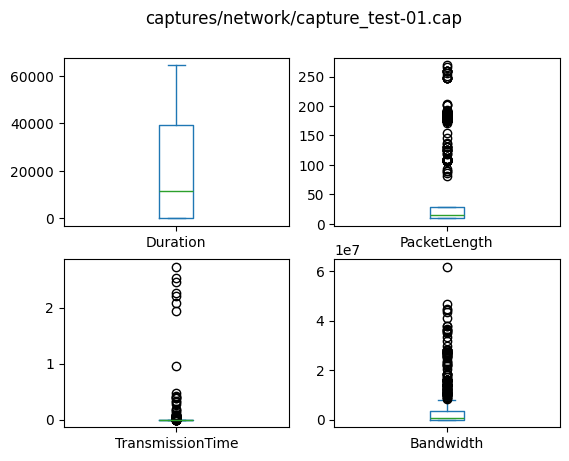

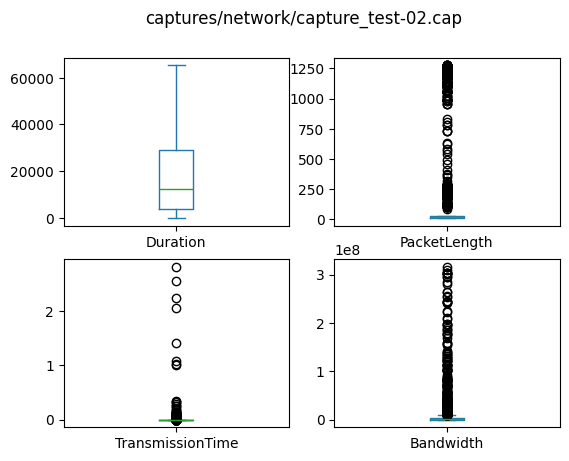

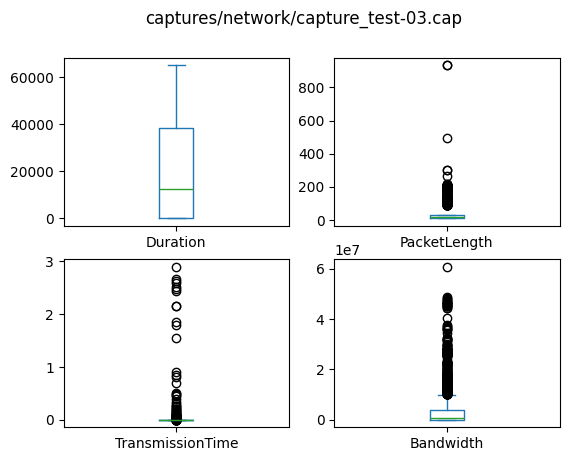

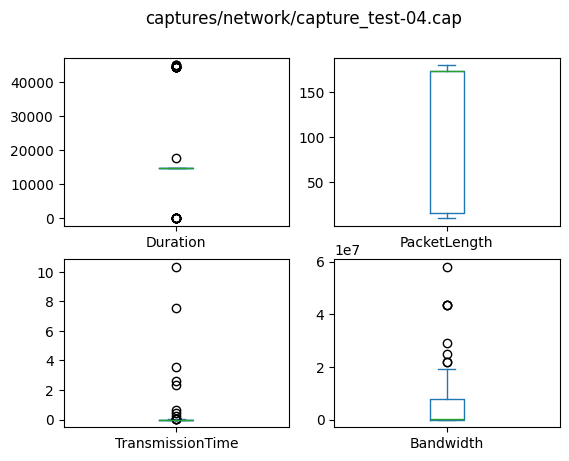

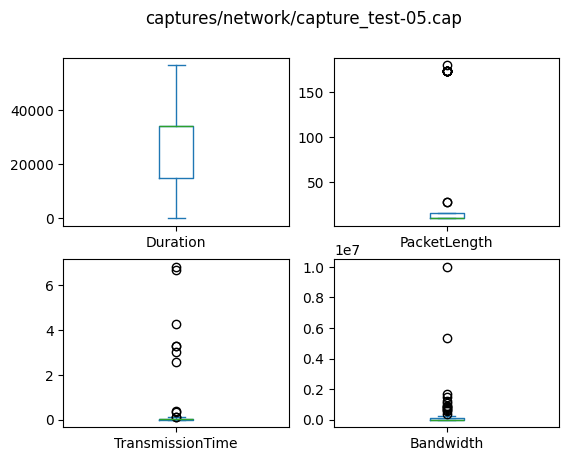

In [7]:
plot_cols = ["Duration", "PacketLength", "TransmissionTime", "Bandwidth"]
for c, f_c in zip(captures_pd, captures_files):
    plot_packets_stat_distribution(capture=c, filename=f_c, save_fig=True)

## Data Cleaning

In [176]:
target_source_address = "0a:1a:cc:8e:ca:9e"
labels = [(0,0), (0,0), (0,1), (0,0), (0,1)]
flows_labeled_l = []

for c, f_c, l in zip(captures_pd, captures_files, labels):
    filtered_capture = c.dropna(axis=0, inplace=False, subset=["SourceAddress"])
    flows = flow_creation(filtered_capture)
    flows_labeled = binary_labeler(flows=flows, criterion=target_source_address, label_name="IsMicrophone", label_values=l)
    flows_labeled.to_csv(f"datasets/{f_c}_flows_labeled.csv")
    flows_labeled_l.append(flows_labeled)

In [177]:
flows_labeled_l[3]

,Duration_mean,Duration_sd,Bandwidth_sd,CDF_pl,IsMicrophone
00:c0:ca:a9:cd:ce,22016.980769,NaN,NaN,1788.0,0.0
00:c0:ca:a9:e7:52,0.0,NaN,NaN,0.0,0.0
0a:1a:cc:8e:ca:9e,NaN,NaN,NaN,NaN,0.0


### Causality

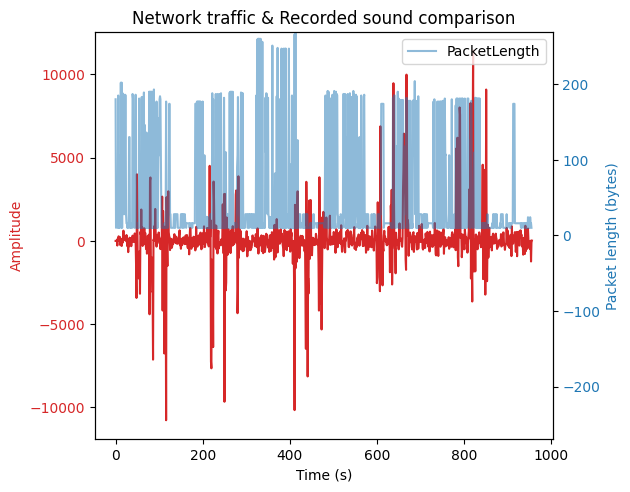

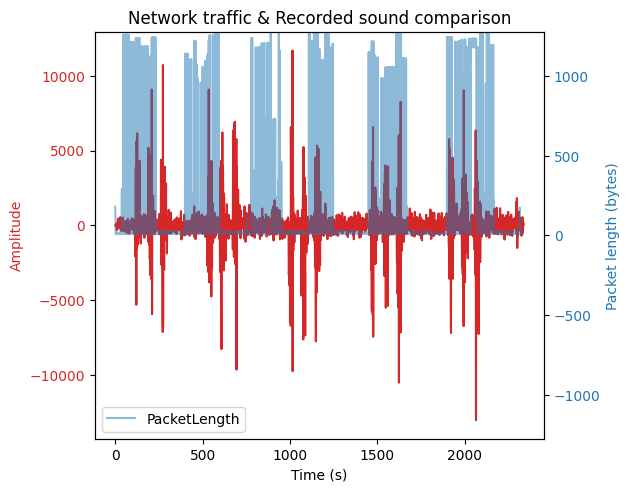

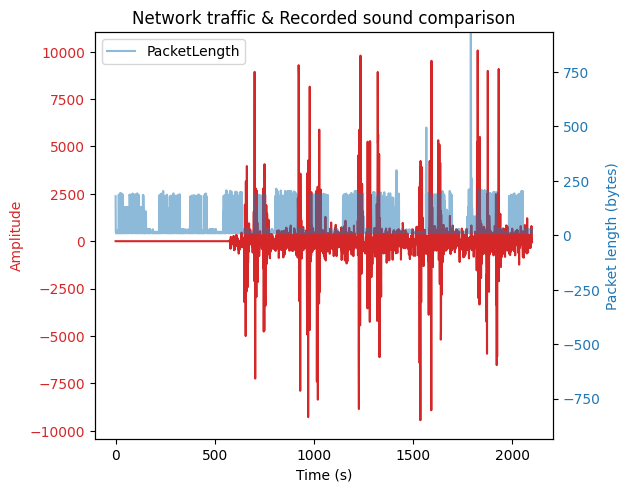

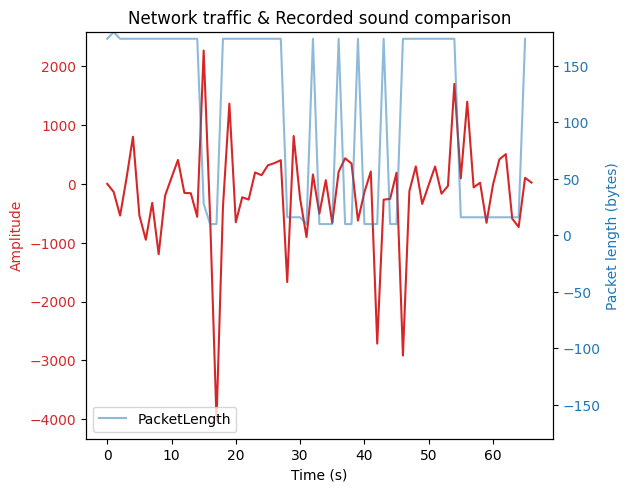

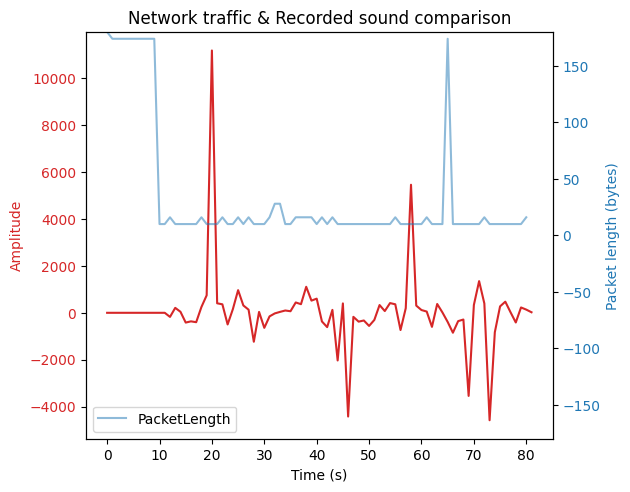

In [98]:
offsets = [0.,0.,11.201,0.,4.987]
for network, audio, offset in zip(captures_pd, ringtone_captures, offsets):
    plot_audio_network_comparison(sound_capture=audio[1], network_capture=network, offset=offset, sample_rate=audio[0])

In [ ]:
grange_caus_mat = []
for network, audio, offset in zip(captures_pd, ringtone_captures, offsets):
    sampled = sample_audio(sound_capture=audio[1], network_capture=network, offset=offset, sample_rate=audio[0])
    concat_pd = pd.concat([network.reset_index()["PacketLength"], pd.Series(sampled)], axis=1)
    concat_pd.columns = ["PacketLength", "Sound"]
    grange_caus_mat.append(grangers_causation_matrix(data=concat_pd, variables=concat_pd.columns, verbose=False, maxlag=5))

In [ ]:
grange_caus_mat[0]

In [34]:
import importlib
import utils #import the module here, so that it can be reloaded.
importlib.reload(utils)
from utils import plot_audio_network_comparison, sample_audio

In [113]:
import importlib
import preprocessing #import the module here, so that it can be reloaded.
importlib.reload(preprocessing)

<module 'preprocessing' from '/home/sicco/Documents/ATCNS_project/atcns-demo/preprocessing.py'>

### Concatenation of all the datasets

In [47]:
flows_labeled_l[-1]

,Duration_mean,Duration_sd,Bandwidth_sd,CDF_pl,IsMicrophone,SourceAddress
00:c0:ca:a9:cd:ce,13499.090909,4477.141956,49168.33074,522.0,0.0,00:c0:ca:a9:cd:ce
7c:c2:25:9c:f3:e4,0.0,0.0,1686690.703786,32.0,0.0,7c:c2:25:9c:f3:e4
00:c0:ca:a9:e7:52,29952.0,18486.775752,40468.605209,32.0,0.0,00:c0:ca:a9:e7:52
0a:1a:cc:8e:ca:9e,NaN,NaN,NaN,NaN,1.0,0a:1a:cc:8e:ca:9e


In [40]:
for f in flows_labeled_l:
    f.loc[:, "SourceAddress"] = f.index

full_dataset = pd.concat(flows_labeled_l, axis=0)
full_dataset.to_csv(F"datasets/full_dataset_test-{DATASET_NUMBER}.csv")